# Deterministic System Identification using Subspace Methods

### Imports

Note, for MIMO systems, package slycot must be installed as well.

In [37]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import control_matrices as cm
import control as ct 
from matrepr import mdisplay, to_latex
from IPython.display import display, Latex, HTML

### System
Here, the true state space system $\Sigma$ is created. In reality, we wouldn't know this system or the matrices
defining it. The system is defined as:
$$
    x[k+1] = Ax[k] + Bu \\
    y[k] = Cx[k] + Du
$$
where $A \in \mathbb{R}^{n\times n}, B \in \mathbb{R}^{n\times p}, C \in \mathbb{R}^{q\times n}, D \in \mathbb{R}^{q\times p}$,\
$x \in \mathbb{R}^{n\times 1}, u \in \mathbb{R}^{p\times 1}$ and $y \in \mathbb{R}^{q\times 1}$.\
$n$ is the system order, $p$ the number of inputs and $q$ the number of outputs.

In [38]:
# %% System
A = np.array([[0,1,0,0],
              [-0.5,-0.4,0,-0.5],
              [0,0,0.2,-1],
              [0,0,0,-0.8]]
              )

B = np.array(
    [[0,0],
     [0,1],
     [0,0],
     [1,0]]
)
C = np.array(
    [[1,0,0,0],
     [0,0,2,0]]
    )
D = np.array([[0,0],[0,0]])

In [46]:
display(HTML(r'<h3>System Definition and stability </h3>'))

# This line will raise an error if state space is not
# appropriately dimensioned.
cm.check_state_space_dimensions(A, B, C, D)

display(Latex(r'$A = ' + to_latex(A) + '$, ' + r'$B = ' + to_latex(B) + '$'))
display(Latex(r'$C = ' + to_latex(C) + '$, ' + r'$D = ' + to_latex(D) + '$'))

# We will need the dimensions of the system later.
# p and q is known, but not n.
n = A.shape[0]
p = B.shape[1]
q = C.shape[0]

# Some sanity checks on the system.
truePoles = np.sort_complex(np.linalg.eigvals(A))

if np.all(np.abs(truePoles) < 1):
    stablestr = "A is stable."
else:
    stablestr = "A is not stable."
display(Latex(r'Notation: If the eigenvalues of $M$ are $\lambda_1, \lambda_2 \cdots \lambda_n$,' + 
            r' then $\text{Spectrum}(M) = \left[\lambda_1, \lambda_2 \cdots \lambda_n\right]$'))
display(Latex(rf'$\text{{Spectrum}}(A) = {to_latex(truePoles)} \Rightarrow $ {stablestr}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Checking controllability and observability

In [40]:
display(HTML(r'<h3>System Controllability and Observability </h3>'))

ctr = cm.make_controllability_matrix(A, B)
ctr_rank = np.linalg.matrix_rank(ctr)
ctr_str = fr"=n={n}\rightarrow$ Controllable" if ctr_rank==n else fr"<n={n}\rightarrow$ Not Controllable"
#mdisplay(ctr, title="'Controllability Matrix")
display(Latex(fr"$rank(\mathcal{{C}})={ctr_rank}" + ctr_str))

obs = cm.make_observability_matrix(A, C)
obs_rank = np.linalg.matrix_rank(obs)
obs_str = fr"=n={n}\rightarrow$ Observable" if obs_rank==n else fr"<n={n}\rightarrow$ Not Observable"
#mdisplay(obs, title="'Observability Matrix")
display(Latex(fr"$rank(\mathcal{{O}})={obs_rank}" + obs_str))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Input-output data
Here, we're gathering $N$ input-output data samples which will be used to identify the system. \
White noise uniform is used as an input signal, for reasons that are explained in the next cell.

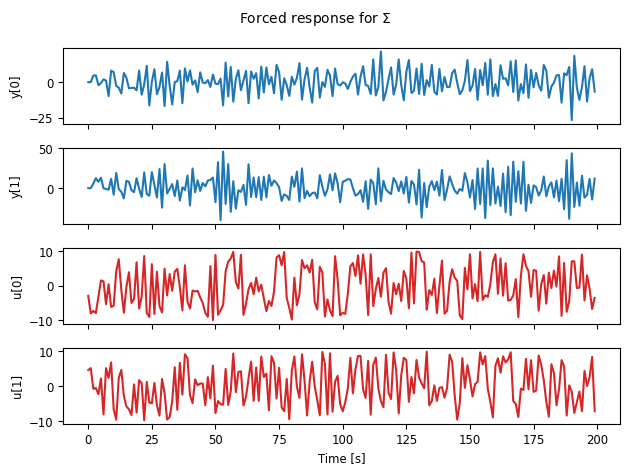

In [47]:
display(HTML(r'<h3> System Input-Output response </h3>'))

### Parameters for input data and system simulation.

# Nr of input samples. Should divide by both p and q
N = 50*q*p
# Input signal(s).
# White noise usually makes for a well conditioned matrix.
u = np.random.uniform(-10, 10, size=(p,N))

true_sys = ct.ss(A,B,C,D,dt=True, name=r'$\Sigma$')
resp = ct.forced_response(true_sys,U=u)
resp.plot()
plt.plot();

### Creating the Hankel Matrices

In [48]:
t = int(N/(2*q))
U = cm.make_Hankel_matrix(u,t,1,p)
Y = cm.make_Hankel_matrix(resp.y, t, 1, q)
iq = int(q*t/2)
ip = int(p*t/2)
Up = U[:ip,:]
Yp = Y[:iq,:]
Uf = U[ip:,:]
Yf = Y[iq:,:]
Wp = np.concatenate([Up, Yp],axis=0)

Upp = U[:ip+p,:]
Ypp = Y[:iq+q,:]
Ufm = U[ip+p:,:]
Yfm = Y[iq+q:,:]
Wpp = np.concatenate([Upp, Ypp],axis=0)

### Estimating the state vectors

In [43]:
# Finding G from Y by multiplying with null space of U
PI_Uf = np.eye(Uf.shape[1]) - np.linalg.pinv(Uf)@Uf
G = (Yf@PI_Uf)@np.linalg.pinv(Wp@PI_Uf)@Wp

PI_Ufm = np.eye(Ufm.shape[1]) - np.linalg.pinv(Ufm)@Ufm
Gm1 = (Yfm@PI_Ufm)@np.linalg.pinv(Wpp@PI_Ufm)@Wpp

# Taking the SVD of G
U_G, s_G, Vh_G = np.linalg.svd(G)
s_G_cutoff = s_G[s_G > np.max(s_G)*1e-3]
n_hat = s_G_cutoff.size
S_G = np.diag(s_G_cutoff)

# Getting the extended observability matrix, estimating Xi0 and Xi1
Obs = (U_G[:,:n_hat]@sqrtm(S_G))
Obs_m1 = Obs[:-q,:]

Xi0 = np.linalg.pinv(Obs)@G
Xi1 = np.linalg.pinv(Obs_m1)@Gm1

### Extracting the system from the state vectors and input-output relations

In [44]:
j = Xi0.shape[1]
Yii = resp.y[:,int(iq/q):int(iq/q)+j]
Uii = u[:,int(ip/p):int(ip/p)+j]

H1 = np.concatenate([Xi1, Yii], axis=0)
H2 = np.concatenate([Xi0, Uii], axis=0)
ABCD = H1@np.linalg.pinv(H2)

A_hat = ABCD[:n_hat, :n_hat]
B_hat = ABCD[:n_hat, n_hat:]
C_hat = ABCD[n_hat:, :n_hat]
D_hat = ABCD[n_hat:, n_hat:]

display(Latex(r'$\hat{A} = ' + to_latex(A_hat) + '$, ' + r'$\hat{B} = ' + to_latex(B_hat) + '$'))
display(Latex(r'$\hat{C} = ' + to_latex(C_hat) + '$, ' + r'$\hat{D} = ' + to_latex(D_hat) + '$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Testing the estimated system

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

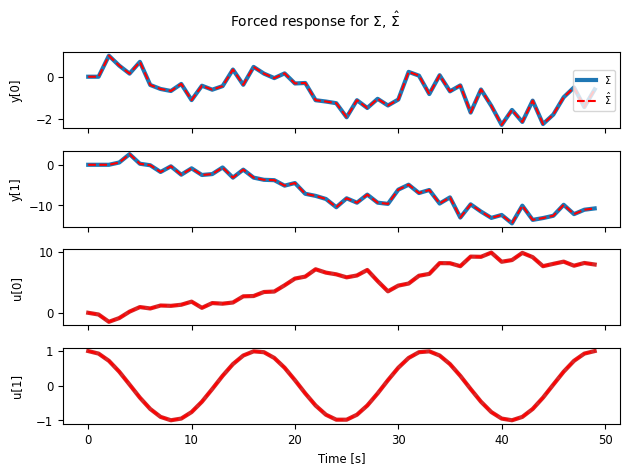

In [45]:
# Creating the estimated system and test signals.
est_sys = ct.ss(A_hat,B_hat,C_hat,D_hat,dt=True,name=r'$\hat{\Sigma}$')
testN = 50
ttest = np.linspace(0,100,testN)
rngu = np.zeros((1,testN))
for i in range(1,testN):
    rngu[0,i] = rngu[0,i-1] + np.random.normal(0,1)
utest = np.concatenate([rngu, np.cos(ttest*(6*np.pi)/100).reshape((1,testN))], axis=0)

# Visual inspection of poles
display(HTML(r'<h3>Comparison of true and estimated system eigenvalues </h3>'))
truePoles = np.sort_complex(np.linalg.eigvals(A))
estPoles = np.sort_complex(np.linalg.eigvals(A_hat))
display(Latex(r'Notation: If the eigenvalues of $M$ are $\lambda_1, \lambda_2 \cdots \lambda_n$,' + 
              r' then $\text{Spectrum}(M) = \left[\lambda_1, \lambda_2 \cdots \lambda_n\right]$'))
display(Latex(rf'$\text{{Spectrum}}(A) = {to_latex(truePoles)}$'))
display(Latex(rf'$\text{{Spectrum}}(\hat{{A}}) = {to_latex(estPoles)}$'))

display(HTML('<hr>'))
display(HTML(r'<h3> Forced Response Comparison of True and Estimated System </h3>'))
# Plotting the forced response for the test signals.
ct.forced_response(true_sys, U=utest).plot(linewidth=3);
ct.forced_response(est_sys, U=utest).plot(linestyle='--', color='r');